##  All figures

This code is largely based on the implementation provided by Enge et al. (2021), available at https://osf.io/34ry2/. We are deeply grateful for their dedication to open research.

> Enge, A., Abdel Rahman, R., & Skeide, M. A. (2021). A meta-analysis of fMRI studies of semantic cognition in children. NeuroImage, 241, 118436. https://doi.org/10.1016/j.neuroimage.2021.118436

In [2]:
# Import necessary modules
from os import makedirs, path
# from atlasreader import get_statmap_info
from IPython.display import display
from nilearn import image, plotting, reporting
from scipy import stats
from scipy.stats import pearsonr
from glob import glob
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
import os, fnmatch

import re

### Figures- ALE results

#### Figure 1.  Single analysis: healthy control group

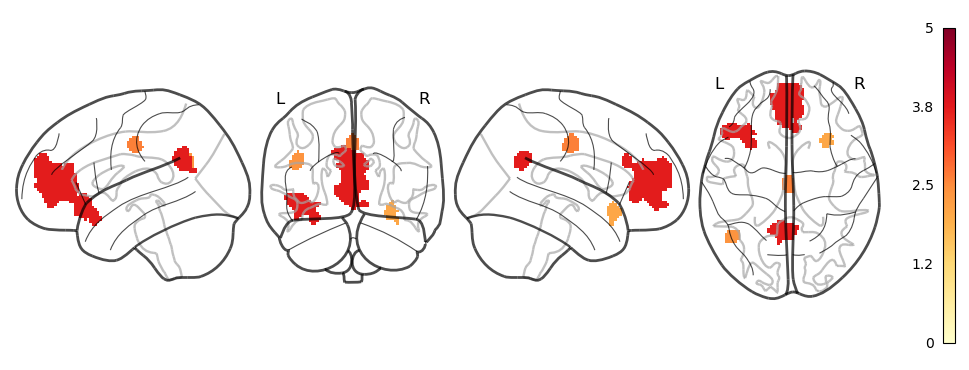

In [24]:
# Figure 1 -  single analysis - healthy control group

# Define the file path for the Z-thresholded image of the healthy control group
ale_thresh_controls = '../results/ale/control_all_z_size_level_thresh.nii.gz'

# Generate the glass brain visualization for the control group using the ALE-thresholded image
fig1 = plotting.plot_glass_brain(ale_thresh_controls, 
                                 display_mode="lyrz", 
                                 cmap="YlOrRd",
                                 threshold=0,
                                #  vmin=0.001, 
                                 vmax=5,
                                 colorbar=True)

# Save the visualization in multiple formats

plt.savefig('../results/figures/ale_controls.svg')  
plt.savefig('../results/figures/ale_controls.pdf')  
plt.savefig('../results/figures/ale_controls.png')


#### Figure 2.  Single analysis: psychiatric group

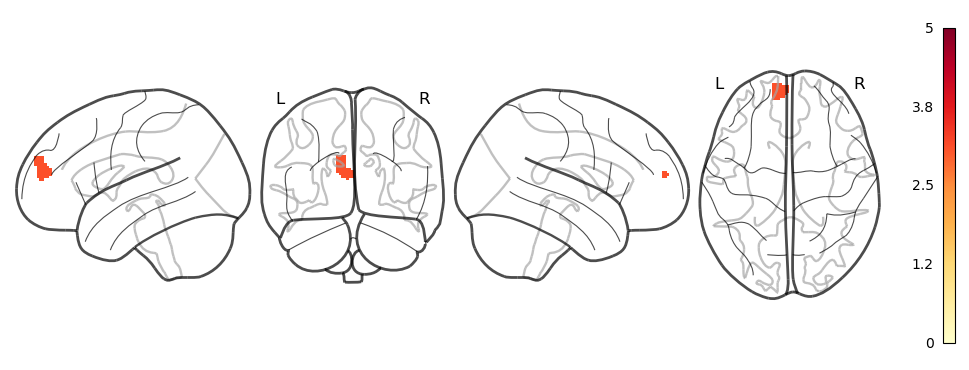

In [30]:
# Figure 2 -  single analysis - psychiatric group

# Define the file path for the Z-thresholded image of the psychiatric group
ale_thresh_z_patients = "../results/ale/patient_z_size_level_thresh.nii.gz"

# Generate the glass brain visualization for the psychiatric group using the ALE-thresholded image
fig2 = plotting.plot_glass_brain(ale_thresh_z_patients, 
                                 display_mode="lyrz",
                                 cmap="YlOrRd", 
                                 threshold=0,
                                #  vmin=0,
                                 vmax=5,
                                 colorbar=True)

# Save the visualization in multiple formats
plt.savefig('../results/figures/ale_patients.svg')  
plt.savefig('../results/figures/ale_patients.pdf')  
plt.savefig('../results/figures/ale_patients.png')

#### Figure 3.  Single analysis: psychiatric group minus healthy control group

/opt/anaconda3/lib/python3.12/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


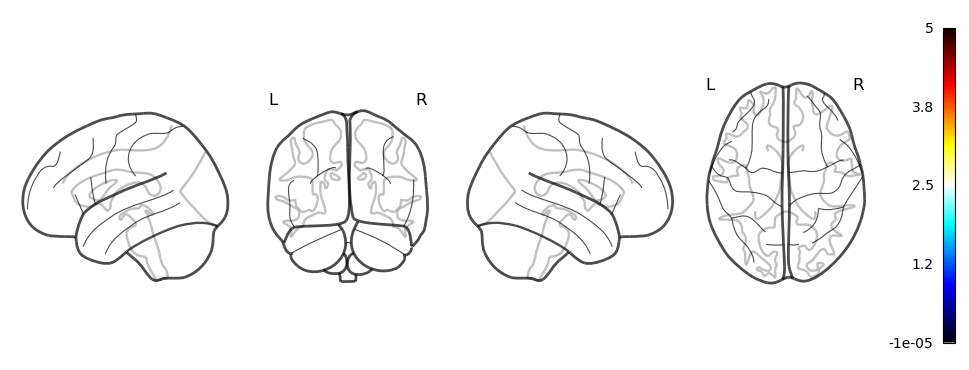

In [ ]:
# Figure 3 -  single analysis - psychiatric group minus healthy control group

# Define the file path for the Z-thresholded image showing the difference between the psychiatric group and the healthy control group
ale_thresh_z_patients_minus_controls = "../results/ale/patient_minus_control_z_size_level_thresh.nii.gz"

# Generate the glass brain visualization for the difference between the psychiatric group and healthy control group
fig3 = plotting.plot_glass_brain(ale_thresh_z_patients_minus_controls, 
                                 display_mode="lyrz", 
                                 cmap="cold_white_hot", 
                                 vmin=0,
                                 vmax=5,
                                 colorbar=True)

# Save the visualization in multiple formats
plt.savefig('../results/figures/ale_patients_minus_controls.svg')  
plt.savefig('../results/figures/ale_patients_minus_controls.pdf')  
plt.savefig('../results/figures/ale_patients_minus_controls.png')

#### Figure 4.  Single analysis:  healthy control group minus psychiatric group

/opt/anaconda3/lib/python3.12/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


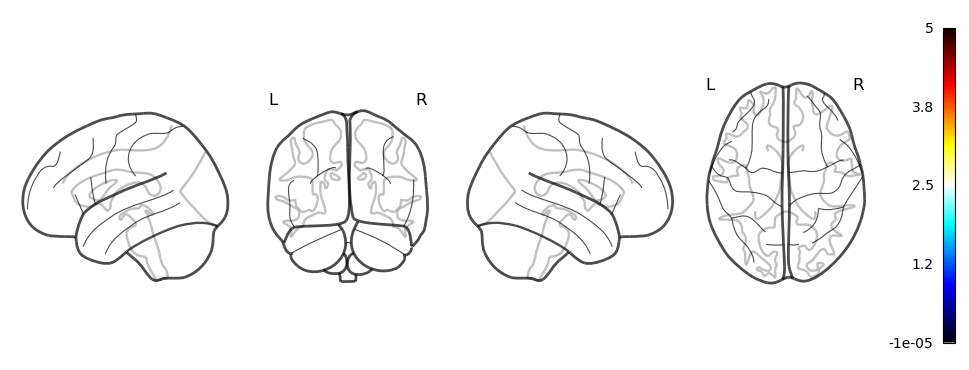

In [ ]:
# Figure 4 -  single analysis - healthy control group minus psychiatric group

# Define the file path for the Z-thresholded image of the healthy control group minus the psychiatric group
ale_thresh_z_controls_minus_patients = "../results/ale/control_minus_patient_z_size_level_thresh.nii.gz"

# Generate the glass brain visualization for the difference between the control and psychiatric groups
fig3 = plotting.plot_glass_brain(ale_thresh_z_controls_minus_patients, 
                                 display_mode="lyrz", 
                                 cmap="cold_white_hot", 
                                 vmin=0,
                                 vmax=5,
                                 colorbar=True)

# Save the visualization in multiple formats
plt.savefig('../results/figures/ale_controls_minus_patients.svg')  
plt.savefig('../results/figures/ale_controls_minus_patients.pdf')  
plt.savefig('../results/figures/ale_controls_minus_patients.png')